In [1]:

import random
import warnings

import cv2
import numpy as np
from keras import layers, models
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
class CNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = models.Sequential()
        inputShape = (height, width, depth)
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
        # model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(2, 2))     
        model.add(layers.Dropout(0.2))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        # model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(2, 2))
        model.add(layers.Dropout(0.2))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        # model.add(layers.BatchNormalization())
        model.add(layers.Dense(classes, activation='softmax'))
        return model

In [3]:
def train_cnn(train_images, train_labels, val_images=np.array([]), val_labels=np.array([]), epochs=5):
    model = CNN.build(width=120, height=400, depth=1, classes=8)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])  #98.97 - adam 99.23 - rmsprop
    model.summary()
    if val_images.size != 0 and val_labels.size != 0:
        model.fit(train_images, train_labels, epochs=epochs, batch_size=32, validation_data=(val_images, val_labels))
    else:
        model.fit(train_images, train_labels, epochs=epochs, batch_size=32)
    return model

In [4]:
def evalute_cnn(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f'[INFO] Loss:{test_loss:.4f} Test accuracy: {(test_acc * 100):.4f}')

In [5]:
def calculate_f1_score(model, test_images, test_labels):
    test_prob = model.predict(test_images)
    test_pred = test_prob.argmax(axis=-1)
    f1 = f1_score(test_labels, test_pred, average='weighted')
    print(f'[INFO] F1-Score is:{f1:.4f}')
    return f1

In [6]:
def handle_candle(img_final, width, height, red_candle_pixel_intensity_og, green_candle_pixel_intensity_og,
                  red_candle_pixel_intensity_new, green_candle_pixel_intensity_new,
                  red_candle_lower_wick_pixel_intensity_new, red_candle_upper_wick_pixel_intensity_new,
                  green_candle_lower_wick_pixel_intensity_new, green_candle_upper_wick_pixel_intensity_new,
                  trim, candle_cols: tuple[int, int]):
    candle_cols_trimmed = (candle_cols[0] + trim, candle_cols[1] - trim)

    candle_width = candle_cols[1] - candle_cols[0]
    half_candle_width = candle_width // 2

    candle_wick_cols = (candle_cols[0] + half_candle_width - 1, candle_cols[0] + half_candle_width)

    # Trimming the candle's width by 'trim' pixels on each side
    img_final[:, candle_cols[0]: candle_cols[0] + trim] = 0
    img_final[:, candle_cols[1] - trim: candle_cols[1]] = 0

    candle_color = None
    first_candle_row = None
    last_candle_row = None

    special_case2 = False
    special_case3 = False

    # Finding first real row of candle
    for i in range(height):
        if (img_final[i, candle_cols_trimmed[0]] == red_candle_pixel_intensity_og
                and img_final[i + 1, candle_cols_trimmed[0]] == red_candle_pixel_intensity_og):
            candle_color = "RED"
            first_candle_row = i
            break
        elif (img_final[i, candle_cols_trimmed[0]] == green_candle_pixel_intensity_og
              and img_final[i + 1, candle_cols_trimmed[0]] == green_candle_pixel_intensity_og):
            candle_color = "GREEN"
            first_candle_row = i
            break

    # Handling case where candle is so small that there is only 1 real row in candle
    if first_candle_row is None:
        for i in range(height):
            if img_final[i, candle_cols_trimmed[0]] == red_candle_pixel_intensity_og:
                candle_color = "RED"
                first_candle_row = i
                break
            elif img_final[i, candle_cols_trimmed[0]] == green_candle_pixel_intensity_og:
                candle_color = "GREEN"
                first_candle_row = i
                break

    # Handling case where candle is so small that there are 0 real rows in candle
    if first_candle_row is None:
        special_case2 = True
        for i in range(height):
            if img_final[i, candle_cols_trimmed[0]] != 0 and img_final[
                i, candle_cols_trimmed[0]] < red_candle_pixel_intensity_og:
                candle_color = "RED"
                first_candle_row = i
                break
            elif img_final[i, candle_cols_trimmed[0]] != 0:
                candle_color = "GREEN"
                first_candle_row = i
                break

    # Handling dojis (open and close are the same or almost the same eg. 0.05 difference)
    if first_candle_row is None:
        special_case3 = True

    # Finding last real row of candle
    for i in range(height - 1, -1, -1):
        if (img_final[i, candle_cols_trimmed[0]] == red_candle_pixel_intensity_og
                and img_final[i - 1, candle_cols_trimmed[0]] == red_candle_pixel_intensity_og):
            last_candle_row = i
            break
        elif (img_final[i, candle_cols_trimmed[0]] == green_candle_pixel_intensity_og
              and img_final[i - 1, candle_cols_trimmed[0]] == green_candle_pixel_intensity_og):
            last_candle_row = i
            break

    # Handling case where candle is so small that there is only 1 real row in candle
    if last_candle_row is None:
        for i in range(height - 1, -1, -1):
            if img_final[i, candle_cols_trimmed[0]] == red_candle_pixel_intensity_og:
                last_candle_row = i
                break
            elif img_final[i, candle_cols_trimmed[0]] == green_candle_pixel_intensity_og:
                last_candle_row = i
                break

    # Handling case where candle is so small that there are 0 real rows in candle and 1 or 2 rows
    if last_candle_row is None:
        for i in range(height - 1, -1, -1):
            if img_final[i, candle_cols_trimmed[0]] != 0:
                last_candle_row = i
                break
            elif img_final[i, candle_cols_trimmed[0]] != 0:
                last_candle_row = i
                break

    # Handling dojis (open and close are the same or almost the same eg. 0.05 difference)
    if last_candle_row is None:
        special_case3 = True

    if not special_case2 and not special_case3:
        # Replacing the smudged row before the first candle row with the first real row of the candle
        img_final[first_candle_row - 1, candle_cols_trimmed[0]:candle_cols_trimmed[1]] = \
            red_candle_pixel_intensity_og if candle_color == "RED" else green_candle_pixel_intensity_og
        first_candle_row -= 1

        # Replacing the smudged row after the last candle row with the last real row of the candle
        img_final[last_candle_row + 1, candle_cols_trimmed[0]:candle_cols_trimmed[1]] = \
            red_candle_pixel_intensity_og if candle_color == "RED" else green_candle_pixel_intensity_og
        last_candle_row += 1

    if not special_case3:
        # Finding first row of upper wick if it exists
        upper_wick_first_row = None
        upper_wick_last_row = None

        for i in range(height):
            if (img_final[i, candle_wick_cols[0]] != 0 and i < first_candle_row
                    and img_final[i, candle_wick_cols[0]] not in [red_candle_pixel_intensity_og,
                                                                  green_candle_pixel_intensity_og]):
                upper_wick_first_row = i
                upper_wick_last_row = first_candle_row - 1
                break

        # Finding last row of lower wick if it exists
        lower_wick_first_row = None
        lower_wick_last_row = None

        for i in range(height - 1, -1, -1):
            if (img_final[i, candle_wick_cols[0]] != 0 and i > last_candle_row
                    and img_final[i, candle_wick_cols[0]] not in [red_candle_pixel_intensity_og,
                                                                  green_candle_pixel_intensity_og]):
                lower_wick_last_row = i
                lower_wick_first_row = last_candle_row + 1
                break

    # Handling dojis (Special case 3)
    else:
        upper_wick_first_row = None
        lower_wick_last_row = None

        # Considering upper and lower wick to be half of the total wick size
        for i in range(height):
            if (img_final[i, candle_wick_cols[0]] != 0 and img_final[i, candle_wick_cols[0]] not in [
                red_candle_pixel_intensity_og, green_candle_pixel_intensity_og]):
                upper_wick_first_row = i
                break

        for i in range(height - 1, -1, -1):
            if (img_final[i, candle_wick_cols[0]] != 0 and img_final[i, candle_wick_cols[0]] not in [
                red_candle_pixel_intensity_og, green_candle_pixel_intensity_og]):
                lower_wick_last_row = i
                break

        # Empty candle
        if upper_wick_first_row is None:
            return img_final

        mid_row = (upper_wick_first_row + lower_wick_last_row) // 2

        upper_wick_last_row = mid_row
        lower_wick_first_row = mid_row + 1

    # Replacing the upper wick with the new intensity
    if upper_wick_first_row is not None:
        img_final[upper_wick_first_row:upper_wick_last_row + 1, candle_wick_cols[0]:candle_wick_cols[1] + 1] = \
            red_candle_upper_wick_pixel_intensity_new if candle_color == "RED" else green_candle_upper_wick_pixel_intensity_new

    # Replacing the lower wick with the new intensity
    if lower_wick_first_row is not None:
        img_final[lower_wick_first_row:lower_wick_last_row + 1, candle_wick_cols[0]:candle_wick_cols[1] + 1] = \
            red_candle_lower_wick_pixel_intensity_new if candle_color == "RED" else green_candle_lower_wick_pixel_intensity_new

    # Replacing the candle with the new intensity
    if not special_case3:
        img_final[first_candle_row:last_candle_row + 1, candle_cols_trimmed[0]:candle_cols_trimmed[1]] = \
            red_candle_pixel_intensity_new if candle_color == "RED" else green_candle_pixel_intensity_new

    return img_final

In [7]:
def handle_image(img_final, width, height, red_candle_pixel_intensity_og, green_candle_pixel_intensity_og,
                 red_candle_pixel_intensity_new, green_candle_pixel_intensity_new,
                 red_candle_lower_wick_pixel_intensity_new, red_candle_upper_wick_pixel_intensity_new,
                 green_candle_lower_wick_pixel_intensity_new, green_candle_upper_wick_pixel_intensity_new,
                 trim, candle_col_starts: tuple[int], candle_width):
    # Wiping the 0th and last row which are not empty for some reason
    img_final[0, :] = 0
    img_final[-1, :] = 0

    # Removing the pixels that are highlighted between the first and second candle for some reason
    img_final[:, 21] = 0

    # Removing the pixels that are highlighted between the fifth and sixth candle for some reason
    img_final[:, 97] = 0

    # Each candle is 'candle_width'=18 pixels wide

    kwargs = {"width": width, "height": height,
              "red_candle_pixel_intensity_og": red_candle_pixel_intensity_og,
              "green_candle_pixel_intensity_og": green_candle_pixel_intensity_og,
              "red_candle_pixel_intensity_new": red_candle_pixel_intensity_new,
              "green_candle_pixel_intensity_new": green_candle_pixel_intensity_new,
              "red_candle_lower_wick_pixel_intensity_new": red_candle_lower_wick_pixel_intensity_new,
              "red_candle_upper_wick_pixel_intensity_new": red_candle_upper_wick_pixel_intensity_new,
              "green_candle_lower_wick_pixel_intensity_new": green_candle_lower_wick_pixel_intensity_new,
              "green_candle_upper_wick_pixel_intensity_new": green_candle_upper_wick_pixel_intensity_new,
              "trim": trim}

    # The first candle exists from column 3 to 20 (candle_col_starts[0] =3)

    img_final = handle_candle(img_final=img_final,
                              candle_cols=(candle_col_starts[0], candle_col_starts[0] + candle_width), **kwargs)

    # The second candle exists from column 22 to 39 (candle_col_starts[1] = 22)

    img_final = handle_candle(img_final=img_final,
                              candle_cols=(candle_col_starts[1], candle_col_starts[1] + candle_width), **kwargs)

    # The third candle exists from column 41 to 58 (candle_col_starts[2] = 41)

    img_final = handle_candle(img_final=img_final,
                              candle_cols=(candle_col_starts[2], candle_col_starts[2] + candle_width), **kwargs)

    # The fourth candle exists from column 60 to 77 (candle_col_starts[3] = 60)

    img_final = handle_candle(img_final=img_final,
                              candle_cols=(candle_col_starts[3], candle_col_starts[3] + candle_width), **kwargs)

    # The fifth candle exists from column 79 to 96 (candle_col_starts[4] = 79)

    img_final = handle_candle(img_final=img_final,
                              candle_cols=(candle_col_starts[4], candle_col_starts[4] + candle_width), **kwargs)

    # The sixth candle exists from column 98 to 115 (candle_col_starts[5] = 98)

    img_final = handle_candle(img_final=img_final,
                              candle_cols=(candle_col_starts[5], candle_col_starts[5] + candle_width), **kwargs)

    return img_final

In [8]:
def get_numpy_array_for_image(image_path):
    # print(image_path)
    img = cv2.imread(image_path)

    img_transformed = img[:, :, :1]

    img_transformed = 255 - img_transformed

    img_final = np.squeeze(img_transformed, axis=2)

    kwargs = {"img_final": img_final, "width": 120, "height": 400,
              "red_candle_pixel_intensity_og": 43,
              "green_candle_pixel_intensity_og": 180,
              "red_candle_pixel_intensity_new": 20,
              "green_candle_pixel_intensity_new": 235,
              "red_candle_lower_wick_pixel_intensity_new": 20,
              "red_candle_upper_wick_pixel_intensity_new": 20,
              "green_candle_lower_wick_pixel_intensity_new": 235,
              "green_candle_upper_wick_pixel_intensity_new": 235,
              "trim": 2,
              "candle_col_starts": (3, 22, 41, 60, 79, 98),
              "candle_width": 18}

    img_final = handle_image(**kwargs)

    return img_final

In [9]:
import pandas as pd


def csv_to_array(file_path):
    df = pd.read_csv(file_path)
    return np.array(list(df['data_labels']))

In [10]:
import os

current_directory = os.getcwd()

os.chdir("D:/Pycharm Projects")

train_folder = rf"ThesisFinalData\larger_scaled_images_rolling_window_6_limit_90\train"

train_images = []

train_images_list = os.listdir(fr'{train_folder}\images')
train_images_list.sort(key=lambda x: int(x.split('_')[1]))

index = 0
for index, img in enumerate(train_images_list):
    print(index)
    index += 1
    train_images.append(get_numpy_array_for_image(rf'{train_folder}\images\{img}'))

train_images = np.array(train_images)

train_labels = csv_to_array(f'{train_folder}/train_data_labels_absolute_8_limit_90.csv')

test_folder = rf"ThesisFinalData\larger_scaled_images_rolling_window_6_limit_90\test"

test_images = []

test_images_list = os.listdir(fr'{test_folder}\images')
test_images_list.sort(key=lambda x: int(x.split('_')[1]))

index = 0
for index, img in enumerate(test_images_list):
    print(index)
    index += 1
    test_images.append(get_numpy_array_for_image(rf'{test_folder}\images\{img}'))

test_images = np.array(test_images)

test_labels = csv_to_array(f'{test_folder}/test_data_labels_absolute_8_limit_90.csv')

# os.chdir(current_directory)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
num_train_images = len(train_images)
print(f"number of training images: {num_train_images}")
train_images_order = list(range(num_train_images))
random.shuffle(train_images_order)
print(f"train images order {train_images_order}")
print(f"train images initial {train_images}")
print(f"train labels initial {train_labels}")
train_images = train_images[train_images_order]
train_labels = train_labels[train_images_order]
print(f"train images shuffled {train_images}")
print(f"train labels shuffled {train_labels}")

number of training images: 28044
train images order [11077, 17697, 8932, 6755, 542, 26915, 20888, 19111, 501, 4190, 25757, 3372, 999, 18494, 496, 9574, 15416, 19795, 6746, 3179, 5580, 24024, 3349, 7220, 2021, 17554, 7265, 12333, 17949, 8384, 25, 8601, 9698, 9471, 18396, 3798, 6975, 20765, 6658, 15711, 27444, 6549, 17467, 22165, 10056, 25428, 14095, 23878, 24149, 10137, 24804, 23680, 2913, 10847, 22266, 21984, 5432, 3265, 9166, 25981, 23170, 24289, 20659, 2265, 26539, 2994, 11714, 1844, 22734, 7434, 12660, 17591, 20125, 7559, 5946, 7218, 18598, 9233, 24802, 704, 16589, 14999, 26690, 10254, 4651, 22314, 10958, 7312, 13590, 24786, 5808, 12650, 8894, 7155, 20699, 13850, 15222, 26508, 11689, 19168, 26325, 11462, 19165, 23123, 17222, 18076, 10651, 26423, 18747, 24850, 19399, 25176, 21851, 9577, 16157, 22659, 4346, 24910, 27622, 17302, 13395, 14752, 6386, 5362, 24918, 14283, 26109, 12572, 19748, 16614, 13998, 24525, 15898, 4335, 10813, 11438, 8, 16418, 27045, 17113, 24986, 22977, 23312, 10350

In [12]:
print(f"number of training images: {len(train_images)}")
print(f"number of testing images: {len(test_images)}")

number of training images: 28044
number of testing images: 7012


In [13]:
print(f"number of training data labels {len(train_labels)}")
print(f"number of training data labels {len(test_labels)}")

number of training data labels 28044
number of training data labels 7012


In [14]:
all_images_folder = rf"ThesisFinalData\larger_scaled_images_rolling_window_6_limit_90\all images"
all_grayscale_images = {file for file in os.listdir(all_images_folder) if file.endswith('grayscale.png')}

print(f"number of all images: {len(all_grayscale_images)}")
train_plus_test_set = set(train_images_list + test_images_list)
print(train_plus_test_set - all_grayscale_images)
assert train_plus_test_set == all_grayscale_images


number of all images: 35056
set()


In [15]:
print("image shape: ", train_images[0].shape)
print("label: ", train_labels[0])
train_images[0]

image shape:  (400, 120)
label:  2.0


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 400, 120, 1)
test_images = test_images.reshape(test_images.shape[0], 400, 120, 1)

train_images, test_images = train_images / 255, test_images / 255

train_images = train_images.astype('float16')
test_images = test_images.astype('float16')


In [17]:
del all_grayscale_images
del train_plus_test_set
del train_images_list
del test_images_list

In [18]:
train_images

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [19]:
train_images[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float16)

In [20]:
train_labels

array([2., 3., 3., ..., 2., 3., 5.])

In [21]:
print(list(train_labels).count(0))

905


In [22]:
test_labels

array([3., 4., 4., ..., 0., 5., 5.])

In [23]:
print(test_labels[-3:])

[0. 5. 5.]


In [24]:
train_images_dummy = train_images[:9]
test_images_dummy = train_images[:9]
train_labels_dummy = train_labels[:9]
test_labels_dummy = train_labels[:9]
print(train_images_dummy)
print(train_labels_dummy)
print(test_images_dummy)
print(test_labels_dummy)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

In [25]:
# model = train_cnn(train_images_dummy,train_labels_dummy,test_images_dummy,test_labels_dummy, epochs = 5)
# print(model.predict(test_images_dummy))
# evalute_cnn(model,test_images_dummy,test_labels_dummy)
# calculate_f1_score(model,test_images_dummy,test_labels_dummy)
model = train_cnn(train_images, train_labels, test_images, test_labels, epochs=5)
# model = train_cnn(train_images,train_labels)
evalute_cnn(model, test_images, test_labels)
calculate_f1_score(model, test_images, test_labels)

D:\Pycharm Projects\ThesisFinal\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 638s 726ms/step - accuracy: 0.3042 - loss: 1.7481 - val_accuracy: 0.2993 - val_loss: 1.7471
Epoch 2/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 719s 820ms/step - accuracy: 0.3290 - loss: 1.6648 - val_accuracy: 0.2958 - val_loss: 1.7511
Epoch 3/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 819s 934ms/step - accuracy: 0.3690 - loss: 1.5746 - val_accuracy: 0.2989 - val_loss: 1.7746
Epoch 4/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 708s 808ms/step - accuracy: 0.4500 - loss: 1.3799 - val_accuracy: 0.2780 - val_loss: 1.9220
Epoch 5/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 700s 798ms/step - accuracy: 0.5740 - loss: 1.0949 - val_accuracy: 0.2554 - val_loss: 2.2924
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.2850 - loss: 2.1291
[INFO] Loss:2.2924 Test accuracy: 25.5419
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step
[INFO] F1-Score is:0.2364


0.23643173168924678

In [26]:
model_predictions = model.predict(test_images)

220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step


In [27]:
predicted_test_labels = []

for row in model_predictions:
    max_value_in_row = max(row)
    predicted_test_label = list(row).index(max_value_in_row)
    predicted_test_labels.append(predicted_test_label)

predicted_test_labels

[3,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 2,
 4,
 2,
 4,
 3,
 4,
 5,
 5,
 4,
 2,
 6,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 5,
 4,
 3,
 2,
 3,
 3,
 3,
 4,
 3,
 2,
 4,
 4,
 4,
 4,
 4,
 5,
 3,
 3,
 3,
 4,
 2,
 4,
 4,
 3,
 4,
 3,
 3,
 4,
 4,
 3,
 5,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 5,
 5,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 2,
 3,
 4,
 4,
 3,
 3,
 5,
 3,
 3,
 4,
 3,
 4,
 4,
 7,
 3,
 3,
 4,
 5,
 3,
 3,
 3,
 2,
 4,
 5,
 3,
 4,
 4,
 3,
 4,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 3,
 3,
 3,
 1,
 2,
 7,
 4,
 4,
 2,
 4,
 4,
 3,
 3,
 5,
 3,
 3,
 4,
 5,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 1,
 2,
 4,
 3,
 3,
 4,
 5,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 6,
 3,
 7,
 3,
 4,
 3,
 4,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 4,
 3,
 4,
 4,
 2,
 5,
 4,
 0,
 4,
 3,
 5,
 3,
 4,
 3,
 6,
 3,
 2,
 3,
 3,
 3,
 3,
 5,
 4,
 2,
 1,
 4,
 3,
 3,
 4,
 3,
 2,
 4,
 4,
 3,
 3,
 6,


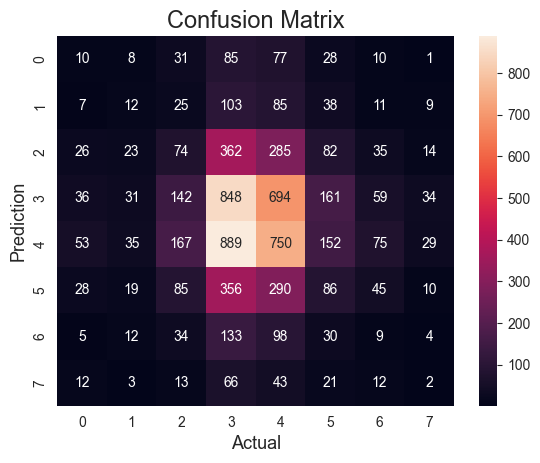

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, predicted_test_labels)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2, 3, 4, 5, 6, 7],
            yticklabels=[0, 1, 2, 3, 4, 5, 6, 7])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()
# Why are these values different from the ones calculated above ?

# TP - predicted 3,4 actual 3,4 = 4655
# TN - predicted 0,1,2,5,6,7 actual 0,1,2,5,6,7 = 74 + 70 + 129 + 98 = 371
# FP - predicted 3,4 actual 0,1,2,5,6,7 = 89 + 167 = 256
# FN - predicted 0,1,2,5,6,7 actual 3,4 = 1768 + 1849 = 3617

# total = 4655 + 371 + 256 + 3617 = 8899

# accuracy = (4655 + 371) / 8899 = 0.56
# recall = 4655 / (4655 + 3617) = 0.56
# F1 = 2 * (0.56 * 0.56) / (0.56 + 0.56) = 0.56

In [29]:
def crossover(c1, c2, min_width=1, h_lower_bound=2, h_upper_bound=10):
    height, width, depth = c1.shape
    start_h = np.random.randint(1, height // 2 + 1)
    end_h = np.random.randint(start_h + h_lower_bound, min(start_h + h_upper_bound, height))
    start_w = np.random.randint(0, width - min_width)
    end_w = np.random.randint(start_w + min_width, width)
    c1_sliced = c1.copy()
    c2_sliced = c2.copy()
    c1_sliced[start_h:end_h, start_w:end_w, :] = c2[start_h:end_h, start_w:end_w, :]
    c2_sliced[start_h:end_h, start_w:end_w, :] = c1[start_h:end_h, start_w:end_w, :]
    return c1_sliced, c2_sliced

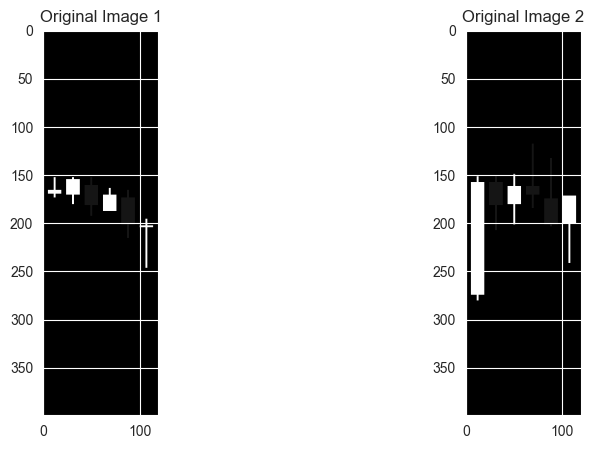

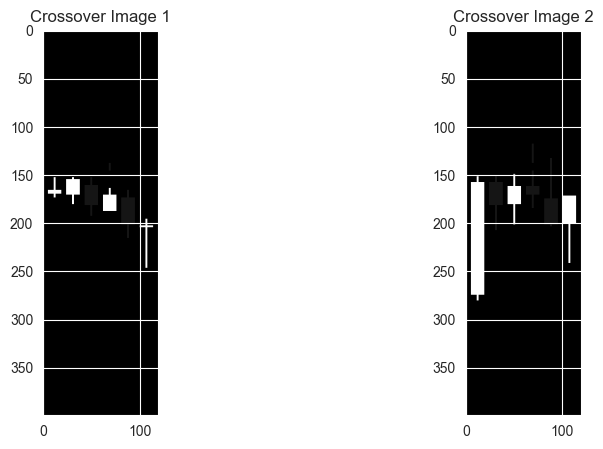

In [30]:
org1 = train_images[np.random.randint(0, len(train_images))]
org2 = train_images[np.random.randint(0, len(train_images))]
c1_crossover, c2_crossover = crossover(org1, org2)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(org1.squeeze(), cmap='gray')
plt.title('Original Image 1')
plt.subplot(1, 2, 2)
plt.imshow(org2.squeeze(), cmap='gray')
plt.title('Original Image 2')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(c1_crossover.squeeze(), cmap='gray')
plt.title('Crossover Image 1')
plt.subplot(1, 2, 2)
plt.imshow(c2_crossover.squeeze(), cmap='gray')
plt.title('Crossover Image 2')
plt.show()

In [31]:
def mutation(m, d=5):
    mutated_image = m.copy()
    step = np.random.randint(-d, d + 1) / 255.
    mask = np.random.choice([True, False], size=mutated_image.shape)
    mutated_image[mask] += step
    return mutated_image

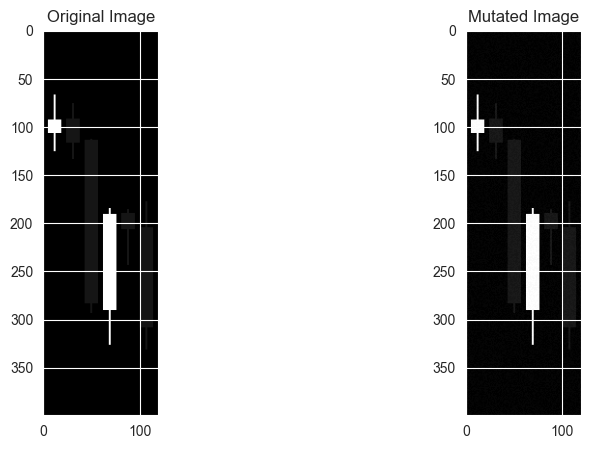

In [32]:
image = train_images[np.random.randint(0, len(train_images))]
mutated_image = mutation(image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mutated_image.squeeze(), cmap='gray')
plt.title('Mutated Image')
plt.show()

In [33]:
def anneal(alpha, mask_a, d=2, lower_bound=2, upper_bound=10):
    alpha = alpha.copy()
    mask_b = np.random.choice([True, False], size=alpha.shape)
    mask = mask_a ^ mask_b
    step = np.random.randint(-d, d + 1, size=alpha.shape) / 225.
    start_h = np.random.randint(0, lower_bound)
    end_h = np.random.randint(alpha.shape[0] - upper_bound, alpha.shape[0])
    start_w = np.random.randint(0, lower_bound)
    end_w = np.random.randint(alpha.shape[1] - upper_bound, alpha.shape[1])
    masksliced = np.zeros(alpha.shape, dtype=bool)
    masksliced[start_h:end_h, start_w:end_w] = mask[start_h:end_h, start_w:end_w]
    # print(masksliced.shape)
    # print(alpha.shape)
    alpha[masksliced] += step[masksliced]
    return alpha

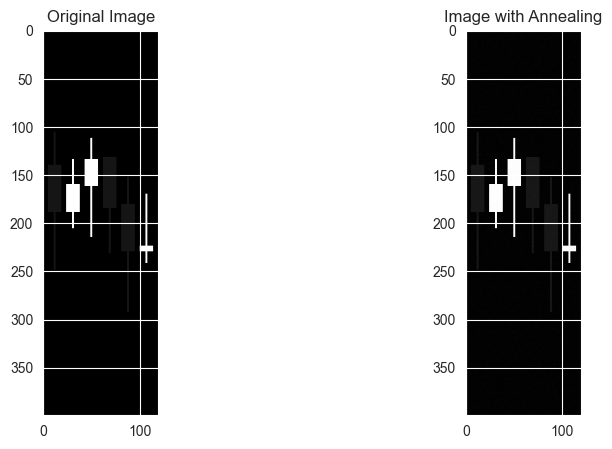

In [34]:
image = train_images[np.random.randint(0, len(train_images))]
mask_a = np.random.choice([True, False], size=image.shape)
anneal_image = anneal(image, mask_a)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(anneal_image.squeeze(), cmap='gray')
plt.title('Image with Annealing')
plt.show()

In [35]:
def calculate_recall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # print(y_test,y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    # print(recall)
    return recall

In [36]:
def fitness(X, Y, alpha_population, model, lambda_value=0.1):
    fitness_values = []
    for alpha, alpha_label in alpha_population:
        # print(alpha.shape)
        # print(alpha_label.shape)      
        # X_fitness = np.concatenate([X, alpha], axis=0)
        # Y_fitness = np.concatenate([Y, alpha_label], axis=0)
        # error = lambda_value * calculate_recall(model,X_fitness,Y_fitness)
        error = lambda_value * calculate_recall(model, alpha, alpha_label)
        alpha_fitness = 1 + error - np.linalg.norm(alpha)
        # print(error,np.linalg.norm(alpha),alpha_fitness)
        fitness_values.append(abs(np.max(alpha_fitness)))
    # best_index = np.argmax(fitness_values)
    # print(best_index)
    return fitness_values  #if needed put this too alpha_population[best_index]

In [37]:
X_sample = train_images[:4]
y_sample = train_labels[:4]
# print(X_sample.shape)
# print(y_sample.shape)
alpha_population_sample = [(np.expand_dims(x, axis=0), np.array([y])) for x, y in zip(X_sample, y_sample)]
# alpha_population_sample = [(np.random.rand(1,28, 28, 1), np.random.randint(0, 5, size=(1,))) for _ in range(3)]
# print(alpha_population_sample)
fitness_values = fitness(X_sample, y_sample, alpha_population_sample, model)
print("Fitness values for the sample alpha population:")
print(fitness_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Fitness values for the sample alpha population:
[47.05625, 30.353125, 34.80625, 46.9625]


In [38]:
def selection(parents, z=0.5):
    fitness_values = fitness(train_images, train_labels, parents, model)
    num_parents = len(parents)
    num_offspring = int(num_parents * z)
    selected_indices = np.random.choice(num_parents, num_offspring, replace=False,
                                        p=fitness_values / np.sum(fitness_values))
    offspring = [parents[i] for i in selected_indices]
    parents_next_gen = [parents[i] for i in range(num_parents) if i not in selected_indices]
    return parents_next_gen, offspring

In [39]:
# X_sample = train_images[:5]
# y_sample = train_labels[:5]
# model = train_cnn(X_sample, y_sample)
# maxpayoff = 0
# exitloop = False
# population = [(np.expand_dims(x, axis=0),np.array([y])) for x,y in zip(X_sample, y_sample)]
# # print(population)
# F_Xtrain = fitness(X_sample, y_sample, population,model)
# print(F_Xtrain)
# gen = 0

# best_index = np.argmax(F_Xtrain)
# print(best_index)
# acurr, currpayoff = population[best_index], F_Xtrain[best_index]  # what is the max show with the fitness example and what is this acurr
# # print(acurr[0],acurr[1])
# print(currpayoff)
# X_sample = np.concatenate([X_sample, acurr[0]], axis=0)
# y_sample = np.concatenate([y_sample, acurr[1]], axis=0)
# model = train_cnn(X_sample, y_sample) 

In [40]:
def twoplayergame_ga(Xtrain, Ytrain, maxiter=100):
    model = train_cnn(Xtrain, Ytrain)
    exitloop = False
    population = [(np.expand_dims(x, axis=0), np.array([y])) for x, y in zip(Xtrain, Ytrain)]
    F_Xtrain = fitness(Xtrain, Ytrain, population, model)
    maxpayoff = np.max(F_Xtrain)
    gen = 0
    while gen < maxiter and not exitloop:
        best_index = np.argmax(F_Xtrain)
        # print(F_Xtrain)
        acurr, currpayoff = population[best_index], F_Xtrain[best_index]
        Xcurr = np.concatenate([Xtrain, acurr[0]], axis=0)
        Ycurr = np.concatenate([Ytrain, acurr[1]], axis=0)
        model = train_cnn(Xcurr, Ycurr, epochs=1)
        print("The currpayoff is :", currpayoff)
        if abs(currpayoff - maxpayoff) < 0.1:  # the currpayoff issue is coming
            maxpayoff = currpayoff
            parents, offspring = selection(population, 0.5)

            new_offspring = []
            for i in range(0, len(offspring) - 1, 2):
                child1, child2 = crossover(np.squeeze(offspring[i][0], axis=0), np.squeeze(offspring[i + 1][0], axis=0))
                new_offspring.append((child1, offspring[i][1]))
                new_offspring.append((child2, offspring[i + 1][1]))

            curr_offspring = []
            for mutant, label in new_offspring:
                curr_offspring.append((np.expand_dims(mutation(mutant), axis=0), label))

            curr_population = parents + curr_offspring
            population = curr_population.copy()
            F_Xtrain = fitness(Xtrain, Ytrain, population, model)
        else:
            exitloop = True

        gen += 1

    final_index = np.argmax(F_Xtrain)
    acurr, maxpayoff = population[final_index], F_Xtrain[final_index]
    return acurr

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 2.0206
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.1236
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 3.6235e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 1.0000 - loss: 4.1723e-06
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 1.0000 - loss: 1.1921e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.0998
The currpayoff is : 47.05625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 2.0669
The currpayoff is : 47.18125
[3.]


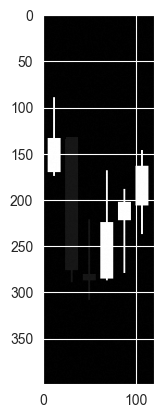

In [41]:
warnings.filterwarnings('ignore')
X_sample = train_images[:5]
y_sample = train_labels[:5]
acurr = twoplayergame_ga(X_sample, y_sample)
print(acurr[1])
plt.imshow(acurr[0].squeeze(), cmap='gray')

In [42]:
def twoplayergame_sa(Xtrain, Ytrain):
    model = train_cnn(Xtrain, Ytrain)
    maxpayoff = 0
    exitloop = False
    Tmax = 10
    Tmin = 5
    v = 5  # this should be 50
    p = 0.6
    mask = np.random.choice([True, False], size=Xtrain[0].shape)
    Tcurr = Tmax
    population = [(np.expand_dims(x, axis=0), np.array([y])) for x, y in zip(Xtrain, Ytrain)]
    random.shuffle(population)
    pop_size = len(population) // 3
    ac = population[:pop_size].copy()
    ag = population[pop_size:2 * pop_size].copy()
    an = population[2 * pop_size:].copy()
    evalc = fitness(Xtrain, Ytrain, ac, model)
    maxpayoff = max(fitness(Xtrain, Ytrain, ag, model))
    while not exitloop:
        evalg = fitness(Xtrain, Ytrain, ag, model)
        curr_index = np.argmax(evalg)
        currpayoff = evalg[curr_index]
        print("The current Payoff is:", currpayoff)
        if abs(currpayoff - maxpayoff) < 0.1:
            maxpayoff = currpayoff
            while Tcurr >= Tmin:
                i = 1
                while i <= v:
                    temp = []
                    for ele, label in ac:
                        temp.append((np.expand_dims(anneal(np.squeeze(ele, axis=0), mask), axis=0), label))
                    an = temp.copy()
                    evaln = fitness(Xtrain, Ytrain, an, model)
                    print(max(evaln), max(evalc), max(evalg))
                    if max(evaln) > max(evalc):
                        ac = an.copy()
                        evalc = evaln.copy()
                        if max(evalg) < max(evaln):
                            ag = an.copy()
                            evalg = evaln.copy()
                    else:
                        if np.random.random() <= np.exp((max(evaln) - max(evalc)) / Tcurr):
                            ac = an.copy()
                            evalc = evaln.copy()
                    i += 1
                Tcurr *= p
            ag = ac.copy()
        else:
            exitloop = True
    return ag[np.argmax(fitness(Xtrain, Ytrain, ag, model))]



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 2.0938
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7000 - loss: 0.5823
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 1.0000 - loss: 0.0826
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 1.0000 - loss: 0.0106
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 1.0000 - loss: 0.0016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The current Payoff is: 48.05625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
42.05625 42.05625 48.05625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/st

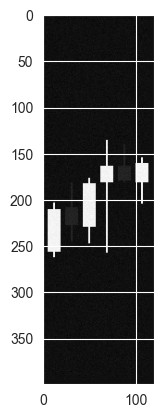

In [43]:
X_sample = train_images[:10]
y_sample = train_labels[:10]
ag = twoplayergame_sa(X_sample, y_sample)
# print(ag)
print(ag[1])
plt.imshow(ag[0].squeeze(), cmap='gray')

In [44]:
def generate_manipulated_data(images, labels, A_s):
    if len(A_s) == 1:
        alphas, alpha_labels = A_s[0][0], A_s[0][1]
    else:
        alphas, alpha_labels = list(zip(*A_s))
        # print(alphas)
        alphas = np.squeeze(alphas, axis=1)
        # print(alphas.shape)
        # print(alpha_labels)
        alpha_labels = np.squeeze(alpha_labels)
        # print(alpha_labels.shape)
    X_manipulated = np.concatenate([images, alphas], axis=0)
    Y_manipulated = np.concatenate([labels, alpha_labels], axis=0)
    return X_manipulated, Y_manipulated

In [45]:
X_sample = train_images[:100]
y_sample = train_labels[:100]
print(X_sample.shape)
print(y_sample.shape)
A_s = [(np.random.rand(1, 400, 120, 1), np.random.randint(0, 5, size=(1,))) for _ in range(10)]
# print(alpha_population_sample)
x_check, y_check = generate_manipulated_data(X_sample, y_sample, A_s)
print(x_check.shape)
print(y_check.shape)

(100, 400, 120, 1)
(100,)
(110, 400, 120, 1)
(110,)


In [46]:
def adversarial_manipulation(X_train, Y_train, X_test, Y_test, M, gametype):
    A_s = []
    for i in range(1, M + 1):
        if gametype == 'GA':
            a_i = twoplayergame_ga(X_train, Y_train)  #remove max_iter
        elif gametype == 'SA':
            a_i = twoplayergame_sa(X_train, Y_train)
        else:
            raise ValueError("Invalid gametype")
        A_s.append(a_i)

    X_train_manipulated, Y_train_manipulated = generate_manipulated_data(X_train, Y_train, A_s)
    X_test_manipulated, Y_test_manipulated = generate_manipulated_data(X_test, Y_test, A_s)

    cnn_model = train_cnn(X_train, Y_train, X_test, Y_test)
    f1_score_manipulated = calculate_f1_score(cnn_model, X_test_manipulated, Y_test_manipulated)

    cnn_model_secure = train_cnn(X_train_manipulated, Y_train_manipulated, X_test_manipulated, Y_test_manipulated)
    f1_score_secure = calculate_f1_score(cnn_model_secure, X_test_manipulated, Y_test_manipulated)

    return A_s, f1_score_manipulated, f1_score_secure

In [47]:
model = train_cnn(train_images[:1000], train_labels[:1000], test_images[:1000], test_labels[:1000])
f1_score_normal = calculate_f1_score(model, test_images, test_labels)

A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images[:1000], train_labels[:1000],
                                                                      test_images[:1000], test_labels[:1000], 1, 'SA')
print(f1_score_normal, f1_score_manipulated, f1_score_secure)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 824ms/step - accuracy: 0.2841 - loss: 1.9012 - val_accuracy: 0.3360 - val_loss: 1.7463
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 819ms/step - accuracy: 0.4035 - loss: 1.5672 - val_accuracy: 0.3110 - val_loss: 1.7014
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 850ms/step - accuracy: 0.6262 - loss: 1.0807 - val_accuracy: 0.2700 - val_loss: 1.9224
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 866ms/step - accuracy: 0.8944 - loss: 0.4036 - val_accuracy: 0.2930 - val_loss: 2.7177
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 879ms/step - accuracy: 0.9840 - loss: 0.1030 - val_accuracy: 0.2960 - val_loss: 3.5957
220/220 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step
[INFO] F1-Score is:0.2408


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 706ms/step - accuracy: 0.2694 - loss: 1.8129
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.3910 - loss: 1.5967
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 642ms/step - accuracy: 0.5784 - loss: 1.1712
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.8389 - loss: 0.5135
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step - accuracy: 0.9674 - loss: 0.1424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 942ms/step - accuracy: 0.2451 - loss: 2.1356 - val_accuracy: 0.3400 - val_loss: 1.6799
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4359 - loss: 1.5919 - val_accuracy: 0.3520 - val_loss: 1.6469
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 895ms/step - accuracy: 0.5207 - loss: 1.3102 - val_accuracy: 0.3170 - val_loss: 1.7563
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 861ms/step - accuracy: 0.7469 - loss: 0.7630 - val_accuracy: 0.3070 - val_loss: 2.1591
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 871ms/step - accuracy: 0.9340 - loss: 0.2515 - val_accuracy: 0.2710 - val_loss: 2.9951
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step
[INFO] F1-Score is:0.2634


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 864ms/step - accuracy: 0.3050 - loss: 2.0996 - val_accuracy: 0.3556 - val_loss: 1.6837
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 848ms/step - accuracy: 0.4064 - loss: 1.6005 - val_accuracy: 0.3297 - val_loss: 1.6684
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 945ms/step - accuracy: 0.4710 - loss: 1.3828 - val_accuracy: 0.3337 - val_loss: 1.7224
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6949 - loss: 0.8686 - val_accuracy: 0.3037 - val_loss: 2.0089
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9398 - loss: 0.3001 - val_accuracy: 0.2777 - val_loss: 2.9021
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step
[INFO] F1-Score is:0.2721
0.24076600820641458 0.2633557931561068 0.27214525141860574


In [48]:
model = train_cnn(train_images[:1000], train_labels[:1000], test_images[:1000], test_labels[:1000])
f1_score_normal = calculate_f1_score(model, test_images, test_labels)

A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images[:1000], train_labels[:1000],
                                                                      test_images[:1000], test_labels[:1000], 1, 'GA')
print(f1_score_normal, f1_score_manipulated, f1_score_secure)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 845ms/step - accuracy: 0.2674 - loss: 1.9252 - val_accuracy: 0.3270 - val_loss: 1.7268
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 918ms/step - accuracy: 0.4011 - loss: 1.5670 - val_accuracy: 0.3420 - val_loss: 1.6222
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 848ms/step - accuracy: 0.5594 - loss: 1.1431 - val_accuracy: 0.3060 - val_loss: 1.8765
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 879ms/step - accuracy: 0.8801 - loss: 0.4511 - val_accuracy: 0.2800 - val_loss: 2.5003
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 822ms/step - accuracy: 0.9801 - loss: 0.1245 - val_accuracy: 0.2970 - val_loss: 3.5669
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step
[INFO] F1-Score is:0.2387


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 791ms/step - accuracy: 0.2562 - loss: 2.1265
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 720ms/step - accuracy: 0.3992 - loss: 1.5798
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 696ms/step - accuracy: 0.5342 - loss: 1.3126
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.7513 - loss: 0.7592
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - accuracy: 0.9586 - loss: 0.2009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 754ms/step - accuracy: 0.2859 - loss: 2.0092
The currpayoff is : 75.2125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 710ms/step - accuracy: 0.2383 - loss: 2.3287
The currpayoff is : 75.3125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 754ms/step - accuracy: 0.2853 - loss: 1.8330
The currpayoff is : 75.3125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 398, 118, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 197, 57, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 98, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │    22,478,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,824 (85.83 MB)

 Trainable params: 22,498,824 (85.83 MB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 685ms/step - accuracy: 0.2728 - loss: 2.1894
The currpayoff is : 75.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━


KeyboardInterrupt



In [ ]:
# model = train_cnn(train_images ,train_labels ,test_images,test_labels)
# f1_score_normal = calculate_f1_score(model,test_images,test_labels)

# A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images,train_labels,test_images,test_labels, 1, 'GA')
# print(f1_score_normal, f1_score_manipulated, f1_score_secure)